# Generating fake data for neo4j analysis 

## Tasks 

### Intro
- <input type="checkbox" checked> incl motivation & stakeholders
    - stakeholders such as authorities can schedule auditing based on most relevant (central) actors rather than arbitrarily 
- <input type="checkbox" checked> simulationsumgebung

### Simple
- <input type="checkbox" checked> Histogramm: Anzahl data categories pro controller
- <input type="checkbox" checked> Histogramm: Purposes pro controller 
- <input type="checkbox" checked> Histogramm: Rechtsgrundlagen - welche am häufigsten? -> speziell: welche legitimen Interessen?
- <input type="checkbox" checked> Histogramm: Anzahl categories pro purpose

### Intermediate
- <input type="checkbox" checked> Clustering data categories
- <input type="checkbox" checked> "category c wird immer nur auf rechtsgrundlage x verarbeitet"
- <input type="checkbox" checked> category-bezogene ketten / nur ketten von controllers

### Advanced
- <input type="checkbox" checked> Sharing networks / clusters
- <input type="checkbox" checked> Anzahl purposes (pro controller / pro category / pro cluster)
- <input type="checkbox" checked> Netzwerk verändert sich über Zeit (es zentralisiert sich mehr, es clustered sich mehr, ... ) / dynamische Simulationen / horizontal
- <input type="checkbox" checked> "Facebook kauft WhatsApp-Szenarien?"
- <input type="checkbox" checked> "was würde massenhaft data portability von instagram zu tiktok auslösen?"
- <input type="checkbox" checked> "Monopole (nur 1 controller verarbeitet datum x) erkennen"
- <input type="checkbox" checked> Verbraucher:innenfreundlichkeit
- <input type="checkbox" checked> personalized privacy policy/dashboard -> user x kann angeben er/sie nutzt diese drölf dienste -> spuck den relevanten graph aus!
- <input type="checkbox" checked> "besser 1 graph pro person als drölf ds-erklärungen"
--

#### WordNet

Similarities (categories clustern?)

# Packages

In [313]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import random as rd
from scipy.stats import poisson
import neo4j
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import networkx as nx

import imageio
import os

# Scraping

In [3]:
def get_table(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    elems = []
    for child in soup.find_all('table')[0].children:

        for some in child:
            row = []
            for i,td in enumerate(some):
                try:
                    row.append(td.text.replace('\n',""))
                except:
                    continue
                if len(row) > 0:
                    elems.append(row)

    return elems
    

try:
    table = get_table("https://www.zyxware.com/articles/4344/list-of-fortune-500-companies-and-their-websites")
    subset = [[table[i][1],table[i][3], table[i][5]]   for i in range(0,len(table), 7)]
    fortune_500 = pd.DataFrame(subset[1:], columns=subset[0])
except: 
    print("scrape now broken")
    pass


In [4]:
#fortune_500.to_csv("fortune_500")

fortune_500 = pd.read_csv('fortune_500')

with open ('categories_tilt', 'rb') as fp:
    categories = pickle.load(fp)

with open ('purpose_tilt', 'rb') as fp:
    purpose = pickle.load(fp)

# Using the Python Driver

In [5]:
from neo4j import GraphDatabase

class exampleTilt:

    """
    class:  exampleTilt
    input:  - uri: bolt uri from neo4j
            - auth: credentials for neo4j
            - no_nodes: number of nodes to create 
            - comp_df:  dataframe with company names and websites
            - mu_poisson_*: average no. of samples for poisson distribution
            - reset: whether to delete all nodes in database (default False, meant for experimentation)

    """

    def __init__(self, uri, auth, no_nodes, comp_df, category_list, purpose_list, mu_poisson_dataDisclosed = 2,  mu_poisson_recipients = 2, reset = False, no_clusters = 5, cluster_weight = 3):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.categories = category_list
        self.purposes = purpose_list
        self.reset = reset

        #number of nodes to push
        self.no_nodes = no_nodes
        
        #company names
        self.company_df = comp_df.head(no_nodes)

        #hyperparameters
        self.mu_poisson_dataDisclosed = mu_poisson_dataDisclosed
        self.mu_poisson_recipients = mu_poisson_recipients
        self.no_clusters = no_clusters
        
        #sort into fake clusters 
        self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]

        self.weight_scaler = cluster_weight
        self.same_cluster = [0, 0]


    def close(self):
        self.driver.close()

    # Create a person node.
    @classmethod
    def createTilt(cls, tx, id, comp_name, url, cluster):
        tx.run("MERGE (t:tilt {id: 0})-[:has_meta]->(m:meta {_id: $id, name: $company_name, created: $created, modified: $placeholder, version: $placeholder, language: $placeholder,  status: $placeholder, url: $url, cluster: $cluster, _hash: $placeholder}) ",
            id=id, 
            cluster = int(cluster),
            company_name = comp_name, 
            created = 3, #time.strftime("%Y:%m:%d, %H:%M:%S"),  we cannot use it with the merge statements because it makes the meta node unique. might have to come up with something here. placeholder it for now.
            url = url, 
            placeholder = 'None')
            
    def createDataDisclosed(self, tx,comp_name, _id, cluster):
        tx.run("MATCH (t:tilt)-[:has_meta]->(m:meta {name: $company_name}) "
               "MERGE (t)-[:has_dataDisclosed]->(d:dataDisclosed {_id: $_id, category: $placeholder, legalBases: $placeholder, legitimateInterests: $placeholder, nonDisclosure: $placeholder, storage: $placeholder}) "
               "MERGE (d)-[:has_purpose]->(p:purpose {purpose: $purpose, description: $placeholder}) ",
                company_name = comp_name, 
                purpose = rd.choice(self.purposes),
                _id=str(_id), 
                placeholder = 'Lorem Ipsum'      
        )

        # define weights dict
        weights = {}

        # fill with no of clusters 
        for n in range(self.no_clusters):
            weights[f'{n}'] = 1/self.no_clusters

        # increase weight for cluster of company
        weights[cluster] = weights[cluster]*self.weight_scaler  # another hyperparameter can be how much the weight is scaled

        # scale the weights
        scaled_weights = (pd.Series(weights) / self.company_df.cluster.value_counts(normalize=True))

        exclusion_list = [comp_name]

        # add recipients (as many as drawn from poisson)
        for _ in range(poisson.rvs(self.mu_poisson_recipients, size=1)[0]):
            self.same_cluster[1] += 1

            # select company to share info with df.loc[df['column_name'] == some_value]
            possible_comps = self.company_df.loc[~self.company_df['Company'].isin(exclusion_list)]
  
            shared_with_comp = possible_comps.sample(n=1, weights=possible_comps.cluster.map(scaled_weights))['Company'].values[0]

            if cluster == (possible_comps[possible_comps['Company'] == shared_with_comp]['cluster'].values[0]):
                self.same_cluster[0] += 1

            # create recipient
            tx.run("MATCH (d:dataDisclosed {_id: $_id}) " 
                    "MERGE (d)-[:has_recipient]->(r:recipient {name: $name, division: $placeholder, address: $placeholder, country: $placeholder, representative: $placeholder, email: $placeholder, phone: $placeholder, category: $placeholder}) ",
                    name = shared_with_comp,
                    placeholder = "Lorem Ipsum",
                    _id = str(_id)
                    )
            exclusion_list.append(shared_with_comp)

    # Match and display all friendships.
    def get_query(self, query):

        """
        get results of any query. 
        This is not part of any of the actual main methods but allows to query the graph using cypher

        """

        with self.driver.session(default_access_mode=neo4j.READ_ACCESS) as session_query:
            tx = session_query.begin_transaction()
            result = tx.run(query)
            tx.commit()
            tx.close()
        
        return result

    @classmethod
    def delete_nodes(cls, tx):
        tx.run("MATCH (n) detach delete n")

    
    def get_has_dataShared(self, tx, threshold = .99):

        out = tx.run(
                "MATCH (m_1:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_recipient]-(r:recipient), (m:meta) "
                "WITH m_1, m, r, apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) as w "
                #"WITH apoc.text.levenshteinSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) AS w "
                f"WHERE w >= {threshold} "
                #"CREATE (m_1)-[c:has_dataShared]->(m) "
                #f"WHERE apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) >= {threshold} "
                            
                "CREATE (m_1)-[c:has_dataShared]->(m) "
                "SET c.weight = w "
                "RETURN COUNT(c)")

        print("Sorensen-relationships for Data Sharing Network created:", out.single()[0])

    def get_similarPurpose(self, threshold = .25):

        with self.driver.session() as session_query:
            
            out_pre = session_query.run("MATCH ()-[s:has_similarPurpose]-() return count(s)")
            session_query.run("MATCH ()-[s:has_similarPurpose]-() detach delete s")
            out_post = session_query.run("MATCH ()-[s:has_similarPurpose]-() return count(s)")
            #print("has_similarPurpose nodes deleted: ", out_pre.single()[0], "- Left: ", out_post.single()[0])

            out = session_query.run(
                            "MATCH (m_1:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_purpose]-(p_1:purpose) " 
                            "WITH m_1, p_1 "
                            "MATCH (m_2:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_purpose]-(p_2:purpose) "
                            "WHERE m_1 <> m_2 "
                            "WITH m_1, m_2, p_1, p_2, apoc.text.sorensenDiceSimilarity(apoc.text.clean(p_1.purpose), apoc.text.clean(p_2.purpose)) as w "
                            "Where w>= $threshold "
                            "Merge (m_1)-[c:has_similarPurpose]-(m_2) "
                            "set c.weight = w "
                            "return Count(c) ", 
                            threshold = threshold)
            
            rels_created = out.single()[0]
            
            print("Sorensen-relationships for Purpose Sharing Network created:", rels_created)

            return rels_created



    def main(self):
        saved_bookmarks = []  # To collect the session bookmarks

        if self.reset:
            with self.driver.session() as session_del:
                session_del.write_transaction(self.delete_nodes)
                saved_bookmarks.append(session_del.last_bookmark())
            print("Graph has been cleared")


        for i in tqdm(range(self.no_nodes)):
            
            with self.driver.session() as session_a: 
                session_a.write_transaction(self.createTilt, 
                                            str(self.company_df['Rank'][i]), 
                                            self.company_df['Company'][i], 
                                            self.company_df['Website'][i], 
                                            str(self.company_df['cluster'][i]))

                for d in range(poisson.rvs(self.mu_poisson_dataDisclosed, size=1)[0]):
                    session_a.write_transaction(self.createDataDisclosed, 
                                                self.company_df['Company'][i], 
                                                str(i)+str(d), str(self.company_df['cluster'][i]))
                saved_bookmarks.append(session_a.last_bookmark())

        print("recipients were created: ",self.same_cluster[1])

        with self.driver.session() as session_sorensen: 
            session_sorensen.write_transaction(self.get_has_dataShared)

            print(f"{self.same_cluster[0]/self.same_cluster[1]*100}% of recipients were in the same cluster")


In [6]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)
fakeTilt.main()

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 16.96it/s]


recipients were created:  101
Sorensen-relationships for Data Sharing Network created: 101
94.05940594059405% of recipients were in the same cluster


## Clustering of puposes 

* next step is to non-randomly distribute the purposes

In [7]:
no_nodes = [fakeTilt.get_similarPurpose(threshold = i/10) for i in range(1,11)]

Sorensen-relationships for Purpose Sharing Network created: 1670
Sorensen-relationships for Purpose Sharing Network created: 978
Sorensen-relationships for Purpose Sharing Network created: 376
Sorensen-relationships for Purpose Sharing Network created: 122
Sorensen-relationships for Purpose Sharing Network created: 40
Sorensen-relationships for Purpose Sharing Network created: 22
Sorensen-relationships for Purpose Sharing Network created: 18
Sorensen-relationships for Purpose Sharing Network created: 18
Sorensen-relationships for Purpose Sharing Network created: 18
Sorensen-relationships for Purpose Sharing Network created: 14


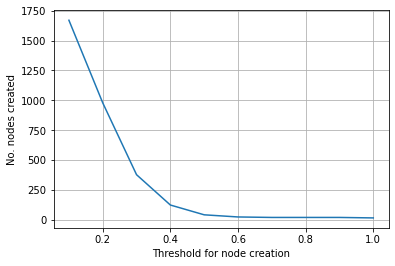

In [8]:
plt.plot([i/10 for i in range(1,11)], no_nodes)
plt.xlabel("Threshold for node creation")
plt.ylabel("No. nodes created")
plt.grid()

## Using the GDS library for python

- documentation https://neo4j.com/docs/graph-data-science-client/current/getting-started/
- Louvain algorithm: https://www.youtube.com/watch?v=0zuiLBOIcsw


In [9]:
from graphdatascience import GraphDataScience

In [10]:
gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 19, 'min': 0, 'max': 19, 'mean': 5.2, ...",make_hist,neo4j,334 KiB,342473,50,260,{'relationshipProjection': {'has_dataShared': ...,0.106122,2022-09-15T14:45:19.839831000+02:00,2022-09-15T14:45:20.955233000+02:00,"{'relationships': {'has_dataShared': {}}, 'nod..."


### Analysis

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 16.94it/s]


recipients were created:  59
Sorensen-relationships for Data Sharing Network created: 59
18.64406779661017% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 18.77it/s]


recipients were created:  51
Sorensen-relationships for Data Sharing Network created: 51
76.47058823529412% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 18.10it/s]


recipients were created:  45
Sorensen-relationships for Data Sharing Network created: 45
80.0% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:04<00:00, 11.94it/s]


recipients were created:  64
Sorensen-relationships for Data Sharing Network created: 64
89.0625% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.89it/s]


recipients were created:  42
Sorensen-relationships for Data Sharing Network created: 42
92.85714285714286% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 16.28it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  68
Sorensen-relationships for Data Sharing Network created: 68
97.05882352941177% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 18.06it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  48
Sorensen-relationships for Data Sharing Network created: 48
91.66666666666666% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 16.32it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  51
Sorensen-relationships for Data Sharing Network created: 51
92.15686274509804% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.25it/s]


recipients were created:  43
Sorensen-relationships for Data Sharing Network created: 43
95.34883720930233% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 16.18it/s]


recipients were created:  69
Sorensen-relationships for Data Sharing Network created: 69
95.65217391304348% of recipients were in the same cluster


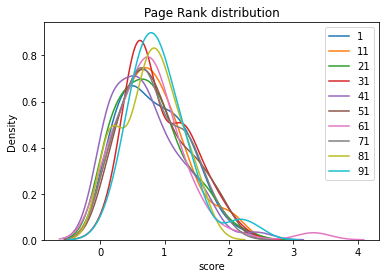

In [11]:
## Some analysis

rd.seed(10)

#set up outcome collectors
community_counts = []
community_dfs = []

recipient_in_cluster = []

#begin the figure
plt.figure()

#iterate through a hyper parameter: here how much do we increase the weight of same cluster nodes for recipient sharing
for prob_scale in range(1,100,10): #add the values to be iterated through

    # make an instance of a database
    fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    cluster_weight = prob_scale,  ### Define the hyperparameter 
                    no_clusters=5,
                    reset=True) #reset has to be true so new graphs are created

    fakeTilt.main() #generate the graph

    recipient_in_cluster.append(fakeTilt.same_cluster[0]/fakeTilt.same_cluster[1])

    try: # get a projection of the graph 
        G,_ = gds.graph.project('prob_scale',
                            ['meta', 
                            #'dataDisclosed', 'tilt', 'recipient'
                                ], 
                            {#'has_meta': {"orientation": "UNDIRECTED"}, 
                            #'has_dataDisclosed': {"orientation": "UNDIRECTED"},
                            #'has_recipient': {"orientation": "UNDIRECTED"}, 
                            'has_dataShared': {"orientation": "UNDIRECTED"}}
                        )
    except: 
        G.drop() # if the projection already exists, delete it and make anew
        G,_ = gds.graph.project('prob_scale',
                            ['meta', 
                            #'dataDisclosed', 'tilt', 'recipient'
                                ], 
                            {#'has_meta': {"orientation": "UNDIRECTED"}, 
                            #'has_dataDisclosed': {"orientation": "UNDIRECTED"},
                            #'has_recipient': {"orientation": "UNDIRECTED"}, 
                            'has_dataShared': {"orientation": "UNDIRECTED"}}
                        )
    
    # run the louvain algorithm. 
    res = gds.louvain.mutate(G, mutateProperty = 'community', nodeLabels = ['meta'], tolerance = 10**(-5))
    
    # get the number of communities found
    community_counts.append(res['communityCount'])

    # collect the number of nodes in each community
    louvain_df = gds.graph.streamNodeProperty(G, 'community')
    community_dfs.append(louvain_df)
    
    #print(gds.graph.streamNodeProperties(G, ['community'], separate_property_columns=True))

    # plot a k-density plot of the page-rank distribution
    sns.kdeplot(gds.pageRank.stream(G)['score'], label = f"{prob_scale}")
    plt.title("Page Rank distribution")
    
    # delete the graph projection
    G.drop()

plt.legend()
plt.show()

In [12]:
print(len(np.unique(louvain_df['propertyValue'])))

9


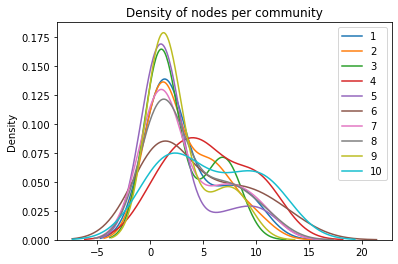

In [13]:
# plotting the number of community members 
plt.figure()

for it, df in enumerate(community_dfs):

    sns.kdeplot(df.value_counts('propertyValue'), label = f'{it+1}')

plt.title("Density of nodes per community")
plt.legend()
plt.show()

Text(0, 0.5, 'No. communities')

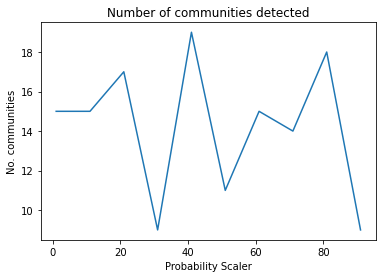

In [14]:
#plotting the number of communities 
plt.plot(range(1,100, 10), community_counts)
plt.title("Number of communities detected")
plt.xlabel("Probability Scaler")
plt.ylabel("No. communities")

In [15]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 100,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    cluster_weight = 10**8,  ### Define the hyperparameter 
                    no_clusters=2,
                    reset=True) #reset has to be true so new graphs are created

fakeTilt.main() #generate the graph

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


recipients were created:  104
Sorensen-relationships for Data Sharing Network created: 104
100.0% of recipients were in the same cluster


## Visuals

Use cypher queries to get an visualualise our database in directly in a jupyter notebook using graphistry

#### Doku
- https://hub.graphistry.com/docs/ui/index/
- https://github.com/graphistry/pygraphistry/blob/master/demos/demos_databases_apis/neo4j/official/graphistry_bolt_tutorial_public.ipynb
- https://hub.graphistry.com/

In [16]:
#!pip install --user graphistry

import graphistry

In [17]:
NEO4J = {
        'uri':'bolt://localhost:11003', 
        'auth' : ('neo4j', 'letmein')
}

graphistry.register(api=3, username='j_halkenhaeusser', password='longlivetransparency22', protocol='https', server='hub.graphistry.com')
graphistry.register(bolt=NEO4J)


In [18]:
graphistry.cypher("""
      match (m:meta)-[s:has_dataShared]-(n:meta), (t:meta) return t, m, s, n
  """).plot()

In [19]:
graphistry.cypher("""
      match (m:meta)-[s:has_dataShared]-(n:meta) return m, s, n
  """).plot()

## Histograms for various graph attributes

In [20]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 19, 'min': 0, 'max': 19, 'mean': 5.2, ...",make_hist,neo4j,334 KiB,342505,50,260,{'relationshipProjection': {'has_dataShared': ...,0.106122,2022-09-15T14:45:19.839831000+02:00,2022-09-15T14:45:20.955233000+02:00,"{'relationships': {'has_dataShared': {}}, 'nod..."


In [22]:
gds.graph.drop(G = gds.graph.get('make_hist'))

graphName                                                    make_hist
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                           50
relationshipCount                                                  260
configuration        {'relationshipProjection': {'has_dataShared': ...
density                                                       0.106122
creationTime                       2022-09-15T14:45:19.839831000+02:00
modificationTime                   2022-09-15T14:45:20.955233000+02:00
schema               {'relationships': {'has_dataShared': {}}, 'nod...
Name: 0, dtype: object

meta    [cluster]
dtype: object


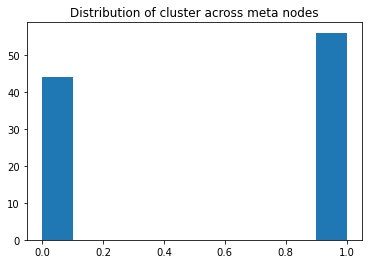

In [23]:
def get_histogram(node_type,
                    attribute, 
                    bolt, 
                    auth,
                    plot_type = 'histogram'): 
    
    gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

    #make a graph projection (/get all the relevant nodes)
    try: # get a projection of the graph 
        G,_ = gds.graph.project('make_hist',
                    {node_type: {"properties": attribute}}, ### does not work because property is a string???  and it only lets me use strings to create node properties???
                    ['has_dataShared']
                )
    except: 
        G = gds.graph.get('make_hist')
        G.drop()
        G,_ = gds.graph.project('make_hist',
                            {node_type: {"properties": attribute}}, ### does not work because property is a string???  and it only lets me use strings to create node properties???
                            ['has_dataShared']
                        )

    print(G.node_properties())

    # collect the attribute
    property_series = gds.graph.streamNodeProperty(G, attribute)

    if plot_type == 'histogram':

        plt.hist(property_series['propertyValue'])
        plt.title(f"Distribution of {attribute} across {node_type} nodes")

    if plot_type == "density":
        # plot a histogram plot of the page-rank distribution
        sns.kdeplot(gds.pageRank.stream(G)['score'], label = f"{prob_scale}")
        plt.title(f"Distribution of {attribute} across {node_type} nodes")
    

    # delete the graph projection
    G.drop()

    plt.show()


get_histogram("meta", 
            'cluster', 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

### Analysing Clusters

In [291]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 5,
                    cluster_weight = 100,
                    reset=True)
fakeTilt.main()

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_21717/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 14.53it/s]


recipients were created:  260
Sorensen-relationships for Data Sharing Network created: 260
93.84615384615384% of recipients were in the same cluster


In [293]:
G,_ = gds.graph.project('make_hist',
                    {'meta': {"properties": 'cluster'}},
                    ['has_dataShared']
                )

In [294]:
res = gds.louvain.mutate(G, mutateProperty = 'community_default') #,seedProperty = 'cluster', maxIterations=1000, tolerance = 10e-15)

In [295]:
res['communityCount']

5

In [214]:
nodes_communities = gds.graph.streamNodeProperties(G, ['cluster', 'community_ml'], separate_property_columns= True)

In [215]:
nodes_communities.groupby(['cluster', 'community_ml']).count()

nodeId
cluster community_ml        
0       0                 11
1       1                  9
        4                  1
2       2                 10
3       3                 10
4       4                  9

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

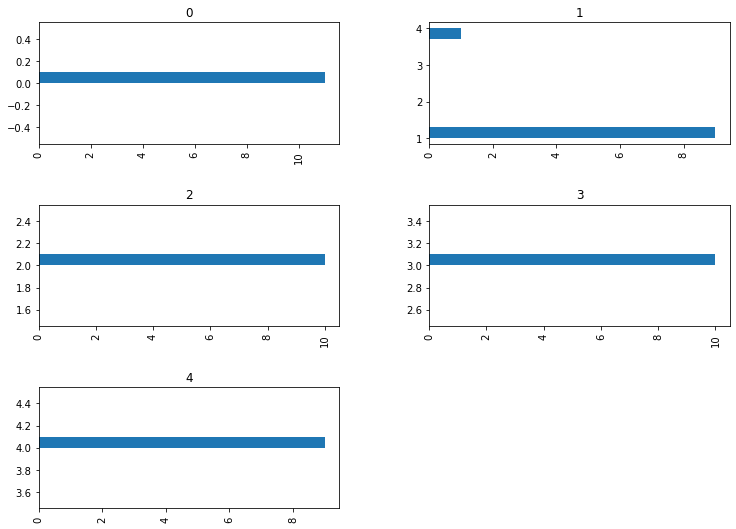

In [216]:
nodes_communities['community_ml'].hist(by=nodes_communities['cluster'], orientation= 'horizontal', figsize=(12,9))

In [142]:
gds.graph.drop(gds.graph.get("GDS"))

graphName                                                          GDS
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                           10
relationshipCount                                                   26
configuration        {'relationshipProjection': {'has_dataShared': ...
density                                                       0.288889
creationTime                       2022-09-22T10:40:58.447178000+02:00
modificationTime                   2022-09-22T10:40:58.450539000+02:00
schema               {'relationships': {'has_dataShared': {}}, 'nod...
Name: 0, dtype: object

## Network Dynamics

In [320]:
ntw = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 10,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)

class sim:

    def __init__(self, network_object, no_steps = 10):

        self.no_steps = no_steps
        self.network = network_object

        self.network.main()


    def visualise(self, driver, iteration):

        curr_dict = pd.DataFrame(driver.run("""
                CALL gds.graph.streamRelationshipProperty(
                'GDS',                  
                'weight'                                 
                )
                YIELD
                sourceNodeId, targetNodeId, relationshipType, propertyValue
                RETURN
                gds.util.asNode(sourceNodeId).name as source, gds.util.asNode(targetNodeId).name as target, relationshipType, propertyValue
                ORDER BY source ASC, target ASC
                """).data())
        
        G = nx.from_pandas_edgelist(curr_dict, 'source', 'target', 'propertyValue')
        
        nx.draw_networkx(G, with_labels = True, font_size = 8)

                # in case we don't want to save an image we can just not specify an iteration
        if iteration != None:  
            plt.savefig(f'{iteration}.png')
            plt.close()
        else:
            plt.show() 

    
    def make_gif(self, n_frames = 5):

        """
        func:   creates a gif from pngs. There need to be images saved by the view method.
        input:  length_sim: number of completed runs of simulation
                n_frames: wait time to slow down gif. default = 5.
        output: saves a gif to wd.
        """

        with imageio.get_writer('mygif.gif', mode='I') as writer:
            filenames = [f"{name}.png" for name in range(self.no_steps)]
            for filename in filenames:
                image = imageio.imread(filename)

                for i in range(n_frames):
                    writer.append_data(image)

        for filename in set(filenames):
            os.remove(filename)

        return

            

    def main(self):
        
        with self.network.driver.session() as s:


            # delete all recipients.
            s.run("match (d:dataDisclosed), (p:purpose) detach delete d, p")

            if gds.graph.exists('GDS').exists == True:
                gds.graph.drop(gds.graph.get("GDS"))

            s.run("""   CALL gds.graph.project(
                        'GDS',
                        'meta',  
                        {
                            has_dataShared: {properties: 'weight'}
                        }
                        )
                        YIELD graphName
                """)

            for i in range(self.no_steps):

                # chose node
                # out = s.run("CALL gds.pageRank.stream('meta', 'has_dataShared', "
                #         "{iterations:20}) "
                #         "YIELD nodeId, score "
                #         "MATCH (node) WHERE id(node) = nodeId "
                #         "RETURN node.name AS page,score "
                #         "ORDER BY score DESC "
                #                        )


                cypher = '''
                        CALL gds.pageRank.stream('GDS')
                        YIELD nodeId, score
                        RETURN gds.util.asNode(nodeId).name AS name,gds.util.asNode(nodeId).cluster AS cluster,  score
                        ORDER BY score DESC, name ASC
                        '''

                dat = pd.DataFrame(s.run(cypher).data())

                #print(dat)
                
                start_node = dat.sample(n=1, weights=dat['score'], axis=0)

                #print(start_node)


                # define weights dict
                weights = {}

                # fill with no of clusters 
                for w in range(self.network.no_clusters):
                    weights[w] = 1/self.network.no_clusters

                # increase weight for cluster of company
                weights[start_node['cluster'].values[0]] *= self.network.weight_scaler  # another hyperparameter can be how much the weight is scaled (gotten from the network object)
                
                # print('Weights',weights)
                # print('VALUE COUNT', dat.cluster.value_counts(normalize=True))
                # scale the weights
                scaled_weights = (pd.Series(weights) / dat.cluster.value_counts(normalize=True))


                shared_with_comp = dat.sample(n=1, weights=dat.cluster.map(scaled_weights))['name'].values[0]

                #print(type(start_node['name'].values[0]))

                s.run('''
                    MATCH (m:meta {name: %r}), (n:meta {name: %r})
                    MERGE (m)-[r:has_dataShared]-(n)
                    SET r.weight = .8
                ''' %(start_node['name'].values[0], shared_with_comp))

                self.visualise(s, i)

                

            #s.run("CALL gds.graph.drop('GDS')")



 
            # randomly generate a recipient based on cluster for a random node. 
            # based on some rule determine the probability of the node being chosen (shorter purpose statements are less specific and hence share more or something like that.)
            # 
            
            # get two nodes and randomly generate a connection if they are in the same cluster. 

            # when you pass a pagerank of .4 all the recipients of one node get passed to that high pagerank node the node is deleted (i.e. some smaller node merges with a bigger node.)

        return s

    

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_95557/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


In [321]:
simulation = sim(ntw, 4)

Graph has been cleared


100%|██████████| 10/10 [00:00<00:00, 15.85it/s]

recipients were created:  15
Sorensen-relationships for Data Sharing Network created: 15
60.0% of recipients were in the same cluster


In [322]:
#gds.graph.streamNodeProperties(gds.graph.get("GDS"),['name'])

In [323]:
driver = simulation.main()

In [324]:
simulation.make_gif()

In [ ]:
def make_gif(length_sim, n_frames = 5):

    """
    func:   creates a gif of the heatmaps. There need to be images saved by the view method.
    input:  length_sim: number of completed runs of simulation
            n_frames: wait time to slow down gif. default = 5.
    output: saves a gif to wd.
    """

    with imageio.get_writer('mygif.gif', mode='I') as writer:
        filenames = [f"{name}.png" for name in range(length_sim+1)]
        for filename in filenames:
            image = imageio.imread(filename)

            for i in range(n_frames):
                writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

    return